In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from astropy.cosmology import FlatLambdaCDM
from astropy import units as u
import datetime

from __future__ import print_function

clight = 299792.458  # speed of light in km/s

In [3]:
# analysis parameters fixed to make figure
sample = "fiducial"  # sample cuts to make (see below)
redshift = "nedfinal" # choices are "literature", "nedhost", "nedfinal", or "flowcorr" 
pecvel_unc = 150.0   # peculiar velocity uncertainty in km/s
distmode = "kinematic"  # use kinematic (q0,j0) or dynamic (Om,Ol) luminosity distance formula
use_median = False # set the Hubble residual and calibrator zeropoints relative to median rather than weighted mean

In [4]:
# cuts list: morphmin, morphmax, ebvmin, ebvmax, dm15min, dm15max, zmin, zmax, mwajmax, calibfile, hflowfile
samples = { "fiducial":   ( -9,  9, -9,   9,  -9, 1.5,   -9,    9,   9, "calibrators.dat", "hubbleflow.dat"), 
# only one choice for paper figure
#             "lowebv":     ( -9,  9, -9, 0.3,  -9, 1.5,   -9,    9,   9, "calibrators.dat", "hubbleflow.dat"),
#             "spirals":    (1.9,  9, -9,   9,  -9, 1.5,   -9,    9,   9, "calibrators.dat", "hubbleflow.dat"),
#             "lowmwaj":    ( -9,  9, -9,   9,  -9, 1.5,   -9,    9, 0.3, "calibrators.dat", "hubbleflow.dat"),
#             "vlowmwaj":   ( -9,  9, -9,   9,  -9, 1.5,   -9,    9,0.15, "calibrators.dat", "hubbleflow.dat"),
#             "restricted": (1.9,  9, -9, 0.3,  -9, 1.3,   -9,    9, 0.3, "calibrators.dat", "hubbleflow.dat"),
#             "stringent":  (1.9,  9, -9, 0.3, 1.0, 1.2,   -9,    9,0.15, "calibrators.dat", "hubbleflow.dat"),
#             "all":        ( -9,  9, -9,   9,  -9,   9,   -9,    9,   9, "calibrators.dat", "hubbleflow.dat"),
#             "z02":        ( -9,  9, -9,   9,  -9, 1.5, 0.02,    9,   9, "calibrators.dat", "hubbleflow.dat"),
#             "z025":       ( -9,  9, -9,   9,  -9, 1.5, 0.025,   9,   9, "calibrators.dat", "hubbleflow.dat"),
#             "z03":        ( -9,  9, -9,   9,  -9, 1.5, 0.03,    9,   9, "calibrators.dat", "hubbleflow.dat"),
#             "z07":        ( -9,  9, -9,   9,  -9, 1.5,   -9, 0.07,   9, "calibrators.dat", "hubbleflow.dat"),
#             "z0207":      ( -9,  9, -9,   9,  -9, 1.5, 0.02, 0.07,   9, "calibrators.dat", "hubbleflow.dat"),
#             "csp":        ( -9,  9, -9,   9,  -9, 1.5,   -9,    9,   9, "calibrators.dat", "hubbleflow_CSP.dat"),
#             "cspall":     ( -9,  9, -9,   9,  -9,   9,   -9,    9,   9, "calibrators.dat", "hubbleflow_CSP.dat"),
#             "csp_calhf":  ( -9,  9, -9,   9,  -9, 1.5,   -9,    9,   9, "calibrators_CSP.dat", "hubbleflow_CSP.dat"),
#             "cfa":        ( -9,  9, -9,   9,  -9, 1.5,   -9,    9,   9, "calibrators.dat", "hubbleflow_CfA.dat"),
#             "cfa_calhf":  ( -9,  9, -9,   9,  -9, 1.5,   -9,    9,   9, "calibrators_CfA.dat", "hubbleflow_CfA.dat"),
#             "cardona":    ( -9,  9, -9,   9,  -9, 1.5,   -9,    9,   9, "calibrators_Cardona.dat", "hubbleflow.dat"),
          }

morphmin, morphmax, ebvmin, ebvmax, dm15min, dm15max, zmin, zmax, mwajmax, calibfile, hflowfile = samples.get(sample) 

print(morphmin, morphmax, ebvmin, ebvmax, dm15min, dm15max, zmin, zmax, mwajmax, calibfile, hflowfile)

# data for calibrators
calib_datafile = calibfile  

# data for Hubble flow objects
hflow_datafile = hflowfile 

-9 9 -9 9 -9 1.5 -9 9 9 calibrators.dat hubbleflow.dat


In [5]:
# output files
output_table = "table_hflow.tex"
output_figure = "fig_hflow.png"

In [6]:
# function to convert peculiar velocity uncertainty (km/s) into magnitudes
#    this includes a small "correction factor" that accounts for the nonlinearity in a std LCDM cosmology
#    the correction factor is negligible at low redshift
def pverr2mag(z,pverr,correction=True):

    if correction:
        assert ((np.min(z) >= 0) and (np.max(z) <= 3)),"Correction factor defined for z=0-3 only"
        correction_coeffs = [1.00171318, 0.74494186, -0.97690614, 0.69153719, -0.28044894, 
                             0.06058092, -0.00537420]
        corrfactor = np.polyval(correction_coeffs[::-1],z)
    else:
        corrfactor = 1.0
        
    return 5.0/np.log(10.0)*pverr/299792.458/z*corrfactor

In [7]:
# function to return distance modulus mu(z) assuming H0=70
#   mode="dynamic" uses flat LCDM cosmology with Om=0.3, Om=0.7 (+ photons,neutrinos)
#   mode="kinematic" uses approximation with q0=-0.55, j0=1
#   negligible difference between these at low redshift
def distmod70(z,mode="dynamic"):
    if mode == "dynamic":
        cosmo = FlatLambdaCDM(H0=70.0, Om0=0.3)
        return 5.0 * np.log10(cosmo.luminosity_distance(z)/u.Mpc) + 25.0
    elif mode == "kinematic":
        q0 = -0.55
        j0 = 1.0
        return 5.0 * np.log10(299792.458*z/70.0 *
                              (1 + (1 - q0)*z/2.0 
                               - (1 - q0 - 3*q0**2 + j0)*(z**2)/6.0)) + 25.0
    else:
        raise ValueError("Undefined mode")    

In [8]:
## Hubble flow objects
hflow_readin = np.genfromtxt(hflow_datafile,dtype=None,
                             names="SN,zlit,zned,znederr,znedfinal,znedfinalerr,zflowcorrected," +
                             "mag,magerr,ebv,dm15,host,hostmorph,morph,mwaj,kcorr,survey")

if redshift == "literature":
    zobstr = "zlit"
elif redshift == "nedhost":
    zobstr = "zned"
    zerrstr = "znederr"
elif redshift == "nedfinal":
    zobstr = "znedfinal"
    zerrstr = "znedfinalerr"
elif redshift == "flowcorr":
    zobstr = "zflowcorrected"
    zerrstr = "znedfinalerr"
else: 
    raise ValueError("Undefined redshift type")

# apply sample cuts
hgood = (  (hflow_readin["ebv"] >= ebvmin) & (hflow_readin["ebv"] <= ebvmax)
         & (hflow_readin["morph"] >= morphmin) & (hflow_readin["morph"] <= morphmax)
         & (hflow_readin["dm15"] >= dm15min) & (hflow_readin["dm15"] <= dm15max) 
         & (hflow_readin[zobstr] >= zmin) & (hflow_readin[zobstr] <= zmax) 
         & (hflow_readin["mwaj"] <= mwajmax) )

all_readin = hflow_readin
hflow_readin = hflow_readin[hgood]

hflow_data = hflow_readin["mag"]
hflow_ptunc = hflow_readin["magerr"]
nhflow = len(hflow_data)

hflow_zobs = hflow_readin[zobstr]
if redshift == "literature":
    hflow_zerr = 0.
else:
    hflow_zerr = hflow_readin[zerrstr]
    
hflow_verr = hflow_zerr * clight

# total z error is redshift measurement uncertainty plus peculiar velocity uncertainty
hflow_totverr = np.sqrt(hflow_verr**2 + pecvel_unc**2)
hflow_totzerr = hflow_totverr / clight

# convert z error into magnitudes
hflow_pvmagerr = pverr2mag(hflow_zobs,hflow_totverr)
hflow_unc = np.sqrt(hflow_ptunc**2 + hflow_pvmagerr**2)

/Users/suhaildhawan/.local/lib/python2.7/site-packages/ipykernel_launcher.py:4: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  after removing the cwd from sys.path.


In [9]:
# for the likelihood function, we pass in the Hubble flow data as the absolute magnitude assuming H0=70
# the best fit H0 is based on the difference between these and the calibrator absolute magnitudes
hflow_mu70 = distmod70(hflow_zobs,mode=distmode)
hflow_M70 = hflow_data - hflow_mu70

# calculate Hubble residuals
hflow_wtmeanM = np.average(hflow_M70,weights=hflow_unc**(-2))
hr = hflow_M70 - hflow_wtmeanM
# use median?
if use_median:
    hr -= np.median(hr)

hpull = hr/hflow_unc
hchisq = np.sum(hpull**2)
sighr = np.std(hr)

print("nhflow: {:d}".format(nhflow))
print("dispersion (stddev of residuals): {:.3f} mag".format(sighr))
print("chisq/dof: {:.1f}/{:d}".format(hchisq,nhflow-1))

nhflow: 27
dispersion (stddev of residuals): 0.106 mag
chisq/dof: 62.8/26


[0.03       0.03076087 0.03152174 0.03228261 0.03304348 0.03380435
 0.03456522 0.03532609 0.03608696 0.03684783 0.0376087  0.03836957
 0.03913043 0.0398913  0.04065217 0.04141304 0.04217391 0.04293478
 0.04369565 0.04445652 0.04521739 0.04597826 0.04673913 0.0475
 0.04826087 0.04902174 0.04978261 0.05054348 0.05130435 0.05206522
 0.05282609 0.05358696 0.05434783 0.0551087  0.05586957 0.05663043
 0.0573913  0.05815217 0.05891304 0.05967391 0.06043478 0.06119565
 0.06195652 0.06271739 0.06347826 0.06423913 0.065      0.06576087
 0.06652174 0.06728261 0.06804348 0.06880435 0.06956522 0.07032609
 0.07108696 0.07184783 0.0726087  0.07336957 0.07413043 0.0748913
 0.07565217 0.07641304 0.07717391 0.07793478 0.07869565 0.07945652
 0.08021739 0.08097826 0.08173913 0.0825     0.08326087 0.08402174
 0.08478261 0.08554348 0.08630435 0.08706522 0.08782609 0.08858696
 0.08934783 0.0901087  0.09086957 0.09163043 0.0923913  0.09315217
 0.09391304 0.09467391 0.09543478 0.09619565 0.09695652 0.09771739


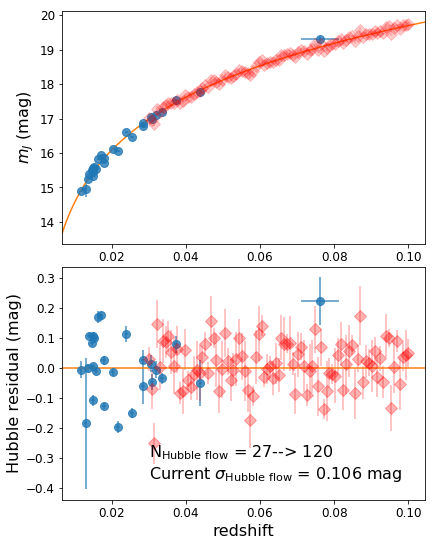

In [19]:
z1 = np.linspace(.03, .1, 93)
print(z1)
fl = FlatLambdaCDM(73., .3)
scat = np.random.normal(0., 0.07, len(z1))
mags_sims = fl.distmod(z1).value - 18.52 + scat
mags_err_sims = np.random.uniform(.03, .1, len(z1)) 
# plot Hubble diagram & residuals
fighflow = plt.figure(figsize=(6.5,9))
plt.subplot('211')
plt.errorbar(hflow_zobs,hflow_data,yerr=hflow_ptunc,xerr=hflow_totzerr,marker='o',linestyle='none',ms=8.,alpha=0.8)
plt.errorbar(z1, mags_sims, mags_err_sims, marker='D', color='r',linestyle='none',ms=8.,alpha=0.2)
plt.ylabel(r"$m_J$ (mag)",fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
zlim = plt.xlim()
zz = np.arange(zlim[0],zlim[1]+0.002,0.001)
plt.plot(zz,distmod70(zz,mode=distmode)+hflow_wtmeanM)
plt.xlim(zlim)
plt.subplots_adjust(hspace=0.1)

plt.subplot('212')
print(len(z1), len(scat), len(mags_err_sims))
plt.errorbar(hflow_zobs,hr,yerr=hflow_ptunc,xerr=hflow_totzerr,marker='o',linestyle='none',ms=8.,alpha=0.8)
plt.errorbar(z1, scat, mags_err_sims, marker='D', color='r',linestyle='none',ms=8.,alpha=0.3)

plt.xlabel(r"redshift",fontsize=16)
plt.ylabel(r"Hubble residual (mag)",fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.plot(zlim,[0,0])
plt.xlim(zlim)
plt.text(0.030,-0.30,r"N$_\mathrm{Hubble\ flow}$ = " + "{:d}".format(nhflow) + "--> 120 ",fontsize=16)
plt.text(0.030,-0.37,r"Current $\sigma_\mathrm{Hubble\ flow}$ = " + "{:.3f} mag".format(sighr),fontsize=16)
plt.savefig('For_app_panel_'+output_figure,bbox_inches="tight")
plt.show()

In [17]:
hsn = np.char.decode(all_readin["SN"])
fsn = np.char.decode(hflow_readin["SN"])
hhost = np.char.decode(all_readin["host"])
hz = all_readin["znedfinal"]
hsigz = all_readin["znedfinalerr"]
hzfc = all_readin["zflowcorrected"]
hm = all_readin["mag"]
hmerr = all_readin["magerr"]
hmwaj = all_readin["mwaj"]
hkcorr = all_readin["kcorr"]
hsamp = np.char.decode(all_readin["survey"])

with open(output_table,"w") as f:
    print("% " + output_table + " created at UT {:%Y-%m-%d %H:%M:%S}".format(datetime.datetime.utcnow()), file=f)
    print(r"\begin{tabular}{|c|c|cc|c|cc|c|c|c|}", file=f)
    print(r"\hline", file=f)
    print(r"Supernova & Host Galaxy & $z_{\rm CMB}$ & $\sigma_z$ & $z_{\rm CMB}$ (flow- & ", file=f)
    print(r"$m_J$ & $\sigma_{\rm fit}$ & MW $A_J$ & $K_J$ & Survey \\", file=f)
    print(r" & or (Cluster) & & & corrected) & (mag) & (mag) & (mag) & (mag) &  \\", file=f)
    print(r"\hline", file=f)

    for i in range(len(hsn)):

        sntext = hsn[i].replace("SN","SN ")
        if hsn[i] not in fsn:
            sntext += r"\tablefootmark{a}"

        host = hhost[i].replace("GC","GC ")
        host = host.replace("IC","IC ")
        host = host.replace("SDSS", "SDSS ")
        host = host.replace("MCG", "MCG ")
        host = host.replace("2MASX", "2MASX ")
        host = host.replace("-","$-$")
        host1 = (host.partition(":"))[0]
        cluster = (host.partition(":"))[2]
        cluster = cluster.replace("Abell","Abell ")
        
        if cluster == "":
            host = host1
        else:
            host = "(" + cluster + ")" 
        
        print(r"{:26s} & {:32s} ".format(sntext,host) +
              r"& {:9.6f} & {:9.6f} & {:9.6f} ".format(hz[i],hsigz[i],hzfc[i]) + 
              r"& {:6.3f} & {:5.3f} ".format(hm[i],hmerr[i]) +
              r"& {:6.3f}  ".format(hmwaj[i]) +              
              r"& ${:6.3f}$ & {:s} ".format(hkcorr[i],hsamp[i]) +
              r" \\", file=f)
    print(r"\hline", file=f)
    print(r"\end{tabular}", file=f)
    
print("output done: " + output_table)

output done: table_hflow.tex
